In [16]:
import sklearn
import sklearn.datasets
import numpy as np
import pandas as pd
from string import ascii_uppercase as LETTERS
from time import time

In [58]:
X, y = sklearn.datasets.make_classification(n_samples=int(10e+5), n_features=4, random_state=42)

In [59]:
X[:,0] = X[:,0].round()
X[:,1] = X[:,1].round()
X[:,2] = (X[:,2] > 0) * 1.

In [60]:
X = pd.DataFrame(X, columns=["categorical", "ordered", "binomial", "real"])

In [61]:
X["categorical"] = [LETTERS[int(x)] for x in X["categorical"]]

In [62]:
X['y'] = y

In [63]:
X.head()

,categorical,ordered,binomial,real,y
0,Z,-0.0,0.0,-1.355158,0
1,C,1.0,0.0,2.145831,1
2,C,1.0,0.0,1.895324,0
3,A,-3.0,1.0,-0.798244,1
4,B,1.0,1.0,1.549485,1


In [64]:
def detect_class(x, n_ = 5):
    n = len(np.unique(x))
    if (n < n_) | (type(x[0]) == str):
        return "cat"
    else:
        return "num"

In [80]:
def build_implication(x,y,n_=5, tolerance = 0.1):
    """
        Forms x -> y from (x,y)
    """
    
    x_c = detect_class(x,n_)
    y_c = detect_class(y,n_)
    
#     print(x_c, y_c)
    
    X = []
    Y = []
    U = []
    
    if (x_c == 'cat') & (y_c == "cat"):
        for value in list(np.unique(x)):
#             print("x =", value, "-> y in", list(np.unique(y[np.where(x == value)])))
            
            X.append(value)
            Y.append(list(np.unique(y[np.where(x == value)])))
            U.append(0)
            
    elif (x_c == 'cat') & (y_c == "num"):
        for value in list(np.unique(x)):
#             print("x =", value, "-> y b/w", (np.min(y[np.where(x == value)]), np.max(y[np.where(x == value)])))
            
            X.append(value)
            Y.append((np.min(y[np.where(x == value)]), np.max(y[np.where(x == value)])))
            U.append(1)
            
    elif (x_c == 'num') & (y_c == "cat"):
        min_ = np.min(x)
        max_ = np.max(x)
        step = (max_ - min_) * tollerance
        distinct_values = list(np.arange(min_, max_, step))
        d = len(distinct_values)
        for i in distinct_values[0:(d-1)]:
                    
            X.append((i, i + step))
            Y.append(list(np.unique(y[np.where((x >= i) & (x < i + step))])))
            U.append(3)
                    
    elif (x_c == 'num') & (y_c == "num"):
        min_ = np.min(x)
        max_ = np.max(x)
        step = (max_ - min_) * tollerance
        distinct_values = list(np.arange(min_, max_, step))
        d = len(distinct_values)
        for i in distinct_values[0:(d-1)]:
#                     print("x in", (i,j), "-> y in ", (np.min(y[np.where((x >= i) & (x <= j))]),
#                                                           np.max(y[np.where((x >= i) & (x <= j))])))

            X.append((i,i + step))
            Y.append((np.min(y[np.where((x >= i) & (x <= i + step))]),
                                                  np.max(y[np.where((x >= i) & (x <= i + step))])))
            U.append(4)
    
#     print(X,Y,U)
    return X,Y,U

In [81]:
def implications(X):
    x_ = {}
    y_ = {}
    u_ = {}
    for i in np.arange(X.shape[1]):
        for j in np.arange(X.shape[1]):
            if i != j:
#                 print(i,j)
                x,y,u = build_implication(X.values[:,i],X.values[:,j],10)
                x_[str(X.columns[i])+str(X.columns[j])] = x
                y_[str(X.columns[i])+str(X.columns[j])] = y
                u_[str(X.columns[i])+str(X.columns[j])] = u
                
    return x_, y_, u_

In [99]:
df = pd.DataFrame({"n":[0], "time":[0]})
for n in [10, 100, 10**3, 10**4, 10**5, 5 * 10**5, 10**6, 2 * 10**6, 5 * 10**6]:
    for _ in np.arange(1):
#         print(n)
        X_ = X.iloc[np.random.uniform(low = 0, high = X.shape[0], size = n).astype('int')]
        t_start = time()
        implications(pd.DataFrame(X_))
        elapsed_time = time() - t_start
        df = df.append({"n":n, "time":elapsed_time}, ignore_index=True)
df

,n,time
0,0.0,0.000000
1,10.0,0.007104
2,100.0,0.011370
3,1000.0,0.039309
4,10000.0,0.418127
5,100000.0,4.784466
6,500000.0,28.016392
7,1000000.0,59.764262
8,2000000.0,125.317533
9,5000000.0,339.326970


In [100]:
import matplotlib.pyplot as plt
%matplotlib inline

/Users/dmitry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


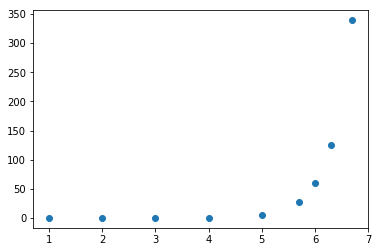

In [101]:
plt.scatter(x = np.log10(df.n.values), y = df.time.values, )

In [75]:
a = X.iloc[:, 1]
b = X.iloc[:, 3]
a[0:10], b[0:10]

(0   -0.0
 1    1.0
 2    1.0
 3   -3.0
 4    1.0
 5    0.0
 6   -1.0
 7    1.0
 8    1.0
 9    1.0
 Name: ordered, dtype: float64, 0   -1.355158
 1    2.145831
 2    1.895324
 3   -0.798244
 4    1.549485
 5   -0.598186
 6   -0.255901
 7   -0.347612
 8    1.346347
 9    0.640503
 Name: real, dtype: float64)

In [159]:
def find_first(item, vec):
    """return the index of the first occurence of item in vec"""
    for i in range(len(vec)):
        if item == vec[i]:
            return i
    return -1

def find_first_range(lower, upper, vec):
    """return the index of the first occurence of item which >= lower and < upper in vec"""
    for i in range(len(vec)):
        if lower <= vec[i]:
            if upper > vec[i]:
                return i
    return -1

In [197]:
def build_and_validate_implication(x, y, x1, y1, n_=5, tolerance = 0.1):
    """
        Forms x -> y from (x,y)
    """
    
    x_c = detect_class(x,n_)
    y_c = detect_class(y,n_)
    
#     print(x_c, y_c)
    
    X = []
    Y = []
    U = []
    
    if (x_c == 'cat') & (y_c == "cat"):
        y1_vals = set(np.unique(y1))
        for value in list(np.unique(x)):
#             print("x =", value, "-> y in", list(np.unique(y[np.where(x == value)])))

            y_vals = list(np.unique(y[np.where(x == value)]))
            verified = False
            for i in y1_vals - set(y_vals):
                if not verified:
                    a = find_first(i, y1[np.where(x1==value)])
#                     print(a)
                    verified = a >= 0
                else:
                    continue
            
            if not verified:
                X.append(value)
                Y.append(y_vals)
                U.append(0)
            
    elif (x_c == 'cat') & (y_c == "num"):
        for value in list(np.unique(x)):
#             print("x =", value, "-> y b/w", (np.min(y[np.where(x == value)]), np.max(y[np.where(x == value)])))
            
            min_, max_ = (np.min(y[np.where(x == value)]), np.max(y[np.where(x == value)]))
        
            verified = False
            
            a = find_first_range(min_, max_, y1[np.where(x1==value)])
            verified = a >= 0
                        
            if not verified:
                X.append(value)
                Y.append((min_, max_))
                U.append(1)
            
    elif (x_c == 'num') & (y_c == "cat"):
        min_ = np.min(x)
        max_ = np.max(x)
        step = (max_ - min_) * tollerance
        distinct_values = list(np.arange(min_, max_, step))
        d = len(distinct_values)
        
        y1_vals = set(np.unique(y1))
        
        for i in distinct_values[0:(d-1)]:
            
            y_vals = list(np.unique(y[np.where((x >= i) & (x < i + step))]))
            verified = False
            for j in y1_vals - set(y_vals):
                if not verified:
                    a = find_first(j, y1[np.where((x1 >= i) & (x1 < i + step))])
#                     print(a, i, i + step, j)
                    verified = a >= 0
                else:
                    continue
                
            if not verified:        
                X.append((i, i + step))
                Y.append(y_vals)
                U.append(3)
                    
    elif (x_c == 'num') & (y_c == "num"):
        min_ = np.min(x)
        max_ = np.max(x)
        step = (max_ - min_) * tollerance
        distinct_values = list(np.arange(min_, max_, step))
        d = len(distinct_values)
        for i in distinct_values[0:(d-1)]:
#                     print("x in", (i,j), "-> y in ", (np.min(y[np.where((x >= i) & (x <= j))]),
#                                                           np.max(y[np.where((x >= i) & (x <= j))])))
            min_, max_ = (np.min(y[np.where((x >= i) & (x <= i + step))]),
                                                  np.max(y[np.where((x >= i) & (x <= i + step))]))
            y_vals = list(np.unique(y[np.where((x >= i) & (x < i + step))]))
            
            a = find_first_range(min_,max_, y1[np.where((x1 >= i) & (x1 < i + step))])
            verified = a >= 0
            
            if not verified:
                X.append((i,i + step))
                Y.append((min_, max_))
                U.append(4)
    
#     print(X,Y,U)
    return X,Y,U

In [198]:
X_ = X.iloc[np.random.uniform(low = 0, high = X.shape[0], size = 100).astype('int')]

x= X_.values[:,3]
y = X_.values[:,1]
x1 = X.values[:,3]
y1 = X.values[:,1]

print(build_and_validate_implication(x, y, x1, y1, n_ = 5))
print(build_implication(x, y, n_ = 5))

([(2.0228822927945025, 2.5562513255292796)], [(1.0, 1.0)], [4])
([(-2.2440699690837143, -1.7107009363489372), (-1.7107009363489372, -1.17733190361416), (-1.17733190361416, -0.643962870879383), (-0.643962870879383, -0.11059383814460588), (-0.11059383814460588, 0.4227751945901712), (0.4227751945901712, 0.9561442273249483), (0.9561442273249483, 1.4895132600597254), (1.4895132600597254, 2.0228822927945025), (2.0228822927945025, 2.5562513255292796)], [(-2.0, -0.0), (-1.0, 1.0), (-1.0, 1.0), (-2.0, 1.0), (-2.0, 2.0), (-1.0, 1.0), (-1.0, 1.0), (0.0, 1.0), (1.0, 1.0)], [4, 4, 4, 4, 4, 4, 4, 4, 4])


In [199]:
def implications_verified(X, X1):
    x_ = {}
    y_ = {}
    u_ = {}
    for i in np.arange(X.shape[1]):
        for j in np.arange(X.shape[1]):
            if i != j:
#                 print(i,j)
                x,y,u = build_and_validate_implication(X.values[:,i],X.values[:,j],X1.values[:,i],X1.values[:,j],10)
                x_[str(X.columns[i])+str(X.columns[j])] = x
                y_[str(X.columns[i])+str(X.columns[j])] = y
                u_[str(X.columns[i])+str(X.columns[j])] = u
                
    return x_, y_, u_

In [200]:
df1 = pd.DataFrame({"n":[0], "time":[0]}) # 10000
for n in [10, 100, 10**3, 10**4, 10**5, 5 * 10**5, 10**6, 2 * 10**6, 5 * 10**6]:
    for _ in np.arange(1):
#         print(n)
        X_ = X.iloc[np.random.uniform(low = 0, high = X.shape[0], size = n).astype('int')]
        X__ = X_.iloc[np.random.uniform(low = 0, high = X_.shape[0], size = 10**4).astype('int')]
        t_start = time()
        implications_verified(pd.DataFrame(X__), pd.DataFrame(X_))
        elapsed_time = time() - t_start
        df1 = df1.append({"n":n, "time":elapsed_time}, ignore_index=True)
df1

,n,time
0,0.0,0.000000
1,10.0,0.422080
2,100.0,0.546580
3,1000.0,0.490700
4,10000.0,0.668079
5,100000.0,2.970233
6,500000.0,13.652049
7,1000000.0,26.254123
8,2000000.0,55.793686
9,5000000.0,144.403921


/Users/dmitry/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


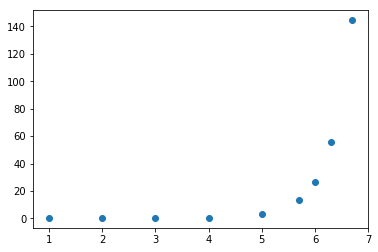

In [201]:
plt.scatter(x = np.log10(df1.n.values), y = df1.time.values, )